In [2]:
import prometheus_pandas.ipython.magic
from prometheus_pandas import query
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
#%%prometheus_query http://localhost:9090 
#    prom_histogram_bucket

In [41]:
p = query.Prometheus('http://localhost:9090')

In [42]:
p.query('prom_histogram_bucket')

prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    11643.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        2271.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="2"}        4664.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="3"}        6991.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="4"}        9291.0
prom_histogram_bucket{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       11643.0
dtype: float64

In [83]:
df = p.query('prom_histogram_bucket[1m]')
df

,"prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""+Inf""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""1""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""2""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""3""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""4""}","prom_histogram_bucket{instance=""host.docker.internal:9184"",job=""HistogramTest"",le=""5""}"
2023-06-23 12:41:05.140000105,27634.0,5508.0,11084.0,16537.0,22057.0,27634.0
2023-06-23 12:41:10.141000032,27644.0,5510.0,11090.0,16545.0,22065.0,27644.0
2023-06-23 12:41:15.140000105,27654.0,5510.0,11092.0,16550.0,22071.0,27654.0
2023-06-23 12:41:20.141000032,27664.0,5511.0,11093.0,16554.0,22078.0,27664.0
2023-06-23 12:41:25.140000105,27674.0,5512.0,11095.0,16558.0,22084.0,27674.0
2023-06-23 12:41:30.141000032,27684.0,5513.0,11098.0,16566.0,22092.0,27684.0
2023-06-23 12:41:35.140000105,27694.0,5513.0,11101.0,16570.0,22096.0,27694.0
2023-06-23 12:41:40.141999960,27704.0,5515.0,11103.0,16576.0,22102.0,27704.0
2023-06-23 12:41:45.141000032,27714.0,5518.0,11109.0,16583.0,22110.0,27714.0
2023-06-23 12:41:50.141000032,27724.0,5520.0,11111.0,16587.0,22115.0,27724.0


In [81]:
df.iloc[11][2] -  df.iloc[0][2]

34.0

In [82]:
lastMinute = p.query('increase(prom_histogram_bucket[1m])')
lastMinute

{instance="host.docker.internal:9184",job="HistogramTest",le="+Inf"}    120.000000
{instance="host.docker.internal:9184",job="HistogramTest",le="1"}        17.454545
{instance="host.docker.internal:9184",job="HistogramTest",le="2"}        36.000000
{instance="host.docker.internal:9184",job="HistogramTest",le="3"}        64.363636
{instance="host.docker.internal:9184",job="HistogramTest",le="4"}        79.636364
{instance="host.docker.internal:9184",job="HistogramTest",le="5"}       120.000000
dtype: float64

In [70]:
lastMinute = p.query('sum(increase(prom_histogram_bucket[1m])) by (le)')
lastMinute

{le="+Inf"}    120.002182
{le="1"}        22.909507
{le="2"}        51.273660
{le="3"}        70.910380
{le="4"}        88.365243
{le="5"}       120.002182
dtype: float64

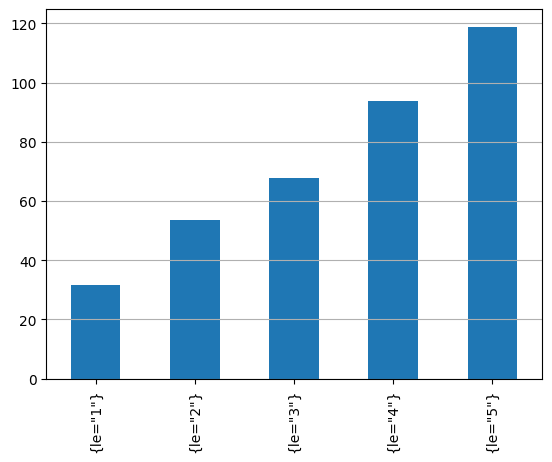

In [45]:
hist = lastMinute[1:].plot.bar()
_ = hist.grid(axis='y');

In [46]:
p.query('histogram_quantile(0.95, increase(prom_histogram_bucket[1m]))') 

{instance="host.docker.internal:9184",job="HistogramTest"}    4.752273
dtype: float64

In [47]:
p.query('histogram_quantile(0.95, sum(increase(prom_histogram_bucket[1m])) by (le))') 

{}    4.752273
dtype: float64

Vi har i alt

lastMinute['{le="5"}']

20 

observationer. 95% fraktil svarer til

In [52]:
0.95 * lastMinute['{le="5"}']

112.9656902852779

Hvilket er et antal observationer inde i bucket 5:

In [53]:
target = 0.95 * lastMinute['{le="5"}'] - lastMinute['{le="4"}']
target

19.14580265095728

Lad os antage, at de observationer som falder i bucket 5 er fordelt ligeligt over bucket 5, så kan vi udregne en hældning:

In [50]:
slope = 1.0 / (lastMinute['{le="5"}'] - lastMinute['{le="4"}'])
slope 

0.039854347826086954

Hvilket bucket indeholder ovenstående request? Det gør bucket 5.

In [51]:
4.0 + slope * target

4.763043478260869

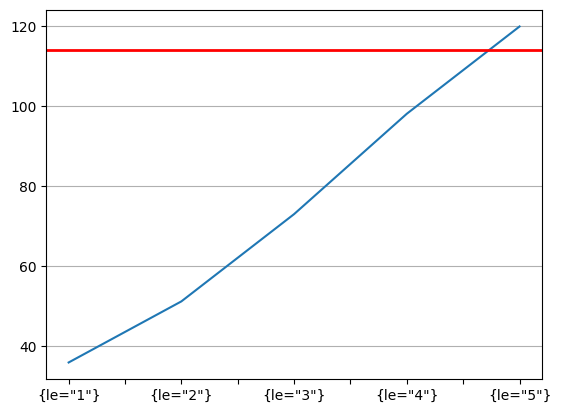

In [39]:
plot = lastMinute[1:].plot(kind='line');
plot.grid(axis='y');
_  = plot.axhline(y=0.95*120, color= 'red', linewidth=2,)